# Gas CART

## Import and load

In [1]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.cluster_generator import ClusterGenerator
from utils.master_generator import MasterGenerator

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils.evaluator import Evaluator
import prince
import numpy as np
from sklearn.svm import SVC, SVR
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


C:\Users\Giovanni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load GAS type cars

In [2]:
data = Loader.load_by_fueltype("Gas")
label_encoder = LabelEncoder()

d:\Duesto Uni\3 anio\Machine Learning\Proyecto\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
d:\Duesto Uni\3 anio\Machine Learning\Proyecto\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
d:\Duesto Uni\3 anio\Machine Learning\Proyecto\Cars_Price_Prediction\Trees\..\utils\loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(va

In [3]:
data["price_categ"].value_counts()

price_categ
Middle low range     509
Budget               480
Low end              250
Middle range          31
Middle high range     16
Very low end           3
High end               1
Luxury                 0
Premiun                0
Name: count, dtype: int64

In [4]:
data['price_categ'] = data['price_categ'].replace({ # Combinar clases similares
    'Luxury': 'Alto',
    'Premiun': 'Alto',
    'High end': 'Alto',
    'Middle high range': 'Alto',
})

data = data[data['price_categ'] != 'Very low end'] # Eliminar la clase 'Very low end'
data['price_categ'] = data['price_categ'].str.strip()

# Revisa la nueva distribución
data['price_categ'].value_counts()

C:\Users\Giovanni\AppData\Local\Temp\ipykernel_7396\787252135.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data['price_categ'] = data['price_categ'].replace({ # Combinar clases similares


price_categ
Middle low range    509
Budget              480
Low end             250
Middle range         31
Alto                 17
Name: count, dtype: int64

In [5]:
# Ajustar y transformar la columna price_categ
data['price_categ'] = data["price_categ"].apply(Loader.encode_price_categ).to_numpy()
data['price_categ'].value_counts()

price_categ
3    509
2    480
1    250
4     31
8     17
Name: count, dtype: int64

#### We can see the data is hightly unbalance and needs treatment before reating the tree model 

Aproach 1

**SMOTE**

This method addresses data imbalance by generating synthetic samples for the minority class.





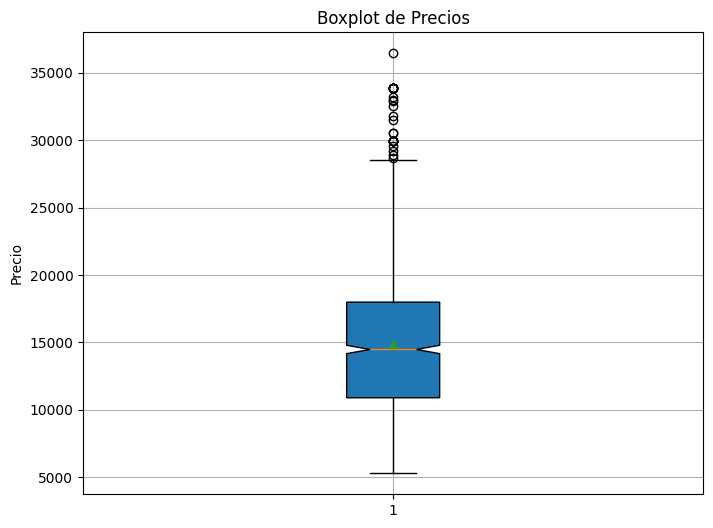

In [6]:
precios_gas = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_gas, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [7]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)

28625.0


,price,brand
idx,,
48483,36441,DFSK
37736,33900,EVO
24917,33900,EVO
40872,33900,EVO
43137,33900,EVO
85825,33900,EVO
91054,33900,EVO
43076,33900,EVO
34644,33899,PIAGGIO


### Gas , Numerical variables selection

In [8]:
def fill_gas_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.height")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")

    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_gas_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])
    numerical_columns.drop(columns=[ "car_id"], inplace=True)

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

    #Remove the column with all NAs
    max_nans = 6586
    thresh = numerical_columns.shape[0] - max_nans

    numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
    return fill_gas_numerical_columns(numerical_columns)

def get_gas_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.select_dtypes(include=['category'])
    ret = ret.drop(columns=["environmentalLabel"]) #All of the cars of this dataframes are electrical which implies 0 emission
    ret = Data_processor.remove_redundand_columns(ret)
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="version")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="jato_classification")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction"], Y="brakes")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    return ret

In [9]:
numerical_columns = get_gas_numerical_columns(data)
categorical_columns = get_gas_categorical_columns(data)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.9674673980367807%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 15.456430834096604%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 5.050674953115149%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 4.822246491513311%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 3.4546319076731025%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 9.788386626797587%
Number of missing values in 'version' before filling with 'unknown': 0
Number of missing values in 'jato_classification' before filling with 'unknown': 6
Number of missing values in 'brakes' before filling with 'unknown': 6
Number of missing values in 'front_suspension' before filling with 'unknown': 0
Number of missing values in 'rear_suspension' before filling with 'unknown': 0


In [10]:
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

price                    1.000000
km                      -0.666253
year                     0.630371
cubicCapacity            0.134931
doors                    0.196730
seatingCapacity          0.262632
trunkCapacityInLiters    0.200050
maxSpeed                 0.029122
acceleration            -0.190765
power_cv                 0.438754
power_kw                 0.444135
max_torque_nm            0.351313
speakers                 0.187856
dimensions.width         0.315454
dimensions.height        0.161946
dimensions.length        0.305562
Numero_Testigos          0.010558
displacement_liters      0.132262
displacement_cc          0.171891
number_of_cylinders     -0.147125
compression_ratio       -0.511080
Llantas_Diametro_cm      0.512251
price_categ              0.890447
Name: price, dtype: float64


In [11]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

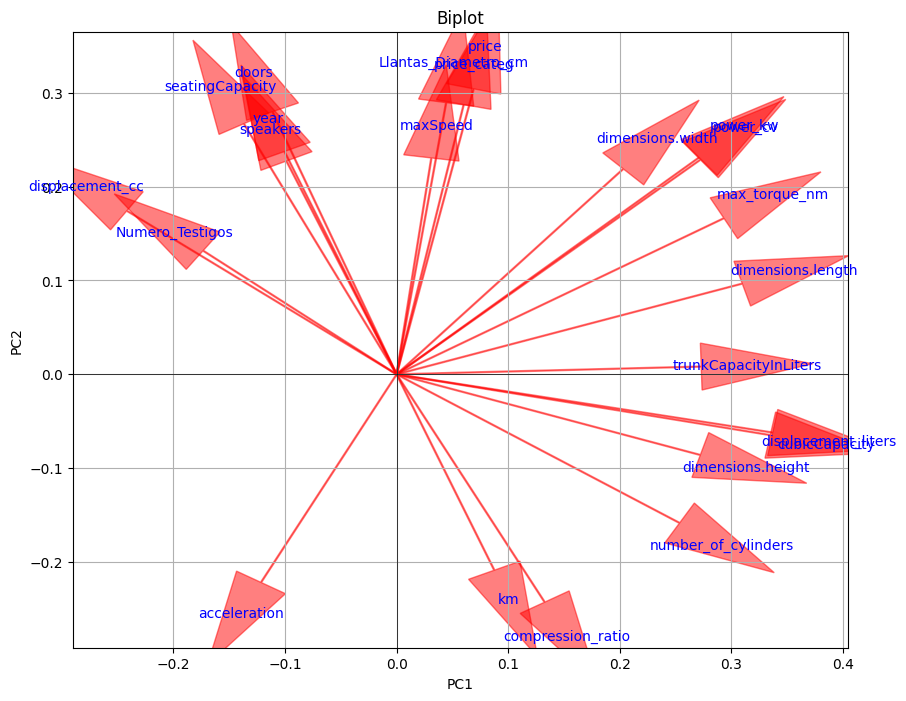

In [12]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

## CART regression with only numerical values

- Using only numerical values we can use the SMOTE technique to generate synthetic value data and rebalance our unbalance dataset.

### SMOTE

In [13]:
X = numerical_columns.drop(columns=["price_categ","price"]) # + price_categ
y = numerical_columns["price_categ"]

In [14]:
# Train-Test Split Before Applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Training the CART Model (Decision Tree) on Resampled Data

In [16]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [17]:
y_pred = clf.predict(X_test)

# Cell 7: Evaluate the Model
# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.78      0.74        45
           2       0.83      0.84      0.83        91
           3       0.96      0.90      0.93       115
           4       0.29      0.40      0.33         5
           8       0.33      0.50      0.40         2

    accuracy                           0.84       258
   macro avg       0.62      0.68      0.65       258
weighted avg       0.85      0.84      0.85       258

Confusion Matrix:
 [[ 35  10   0   0   0]
 [ 12  76   3   0   0]
 [  2   6 103   4   0]
 [  0   0   1   2   2]
 [  0   0   0   1   1]]


After analyzing the results obtained with and without the application of SMOTE, it was observed that models trained without SMOTE demonstrated superior performance in terms of accuracy and stability. Although SMOTE is an effective technique for balancing imbalanced datasets by synthesizing new samples, in this specific case, the models without SMOTE outperformed those with it. 

**Therefore future models will be trained without SMOTE from this point forward.**

# Clasification


In [18]:
def eval_classification(y_test, y_pred):
    result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
    result["diff"] = result["Real"] - result["Prediction"]
    Evaluator.eval_ordinal_classification(diff=abs(result["diff"]))

def classify(X_train, X_test, y_train, y_test , classifier, classifier_name = None) -> None:
    classifier = classifier
    classifier.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = classifier.predict(X_test)
    eval_classification(y_test, y_pred)

    if classifier_name != None:
        return Evaluator.eval_classification(y_pred = y_pred,  y_true=y_test, binary_classification=False, classifier_name=classifier_name)
    return Evaluator.eval_classification(y_pred = y_pred, y_true=y_test, binary_classification=False)



In [19]:
gas_cars = pd.merge(numerical_columns, categorical_columns, left_index=True, right_index=True, how='inner')
numerical_column_names = list(numerical_columns.columns)
categorical_column_names = list(categorical_columns.columns)

target = gas_cars[["price", "price_categ"]]
gas_cars.drop(columns=["price"], inplace=True)

numerical_column_names.remove("price")


encoders_and_scalers = {}
for column in numerical_column_names:
    scaler = StandardScaler()
    gas_cars[[column]] = scaler.fit_transform(gas_cars[[column]])
    encoders_and_scalers[column] = scaler 

gas_cars_encoded = pd.get_dummies(gas_cars, columns=categorical_column_names)

### CART

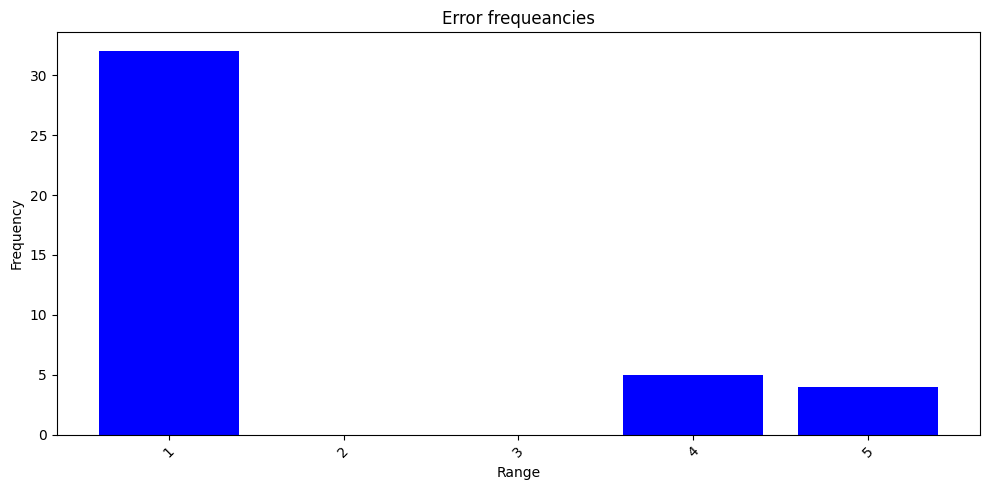

{np.int64(1): np.int64(32), np.int64(4): np.int64(5), np.int64(5): np.int64(4)}
Error mean: 1.7560975609756098
Error rate: 15.891472868217054 %
Overall mean: 0.27906976744186046
Accuracy: 0.8410852713178295 
 Precision: 0.8607956233006353 
 Recall: 0.8410852713178295 
 F1 Score: 0.8494829160700684
Confusion Matrix:
 [[ 37   8   0   0   0]
 [ 11  75   5   0   0]
 [  0   4 104   3   4]
 [  0   0   1   0   4]
 [  0   0   0   1   1]]


In [20]:
classify(X_train, X_test, y_train, y_test, DecisionTreeClassifier(random_state=42), classifier_name="CART")

### Random forest
Random forest can get a better result at a higher computational time cost

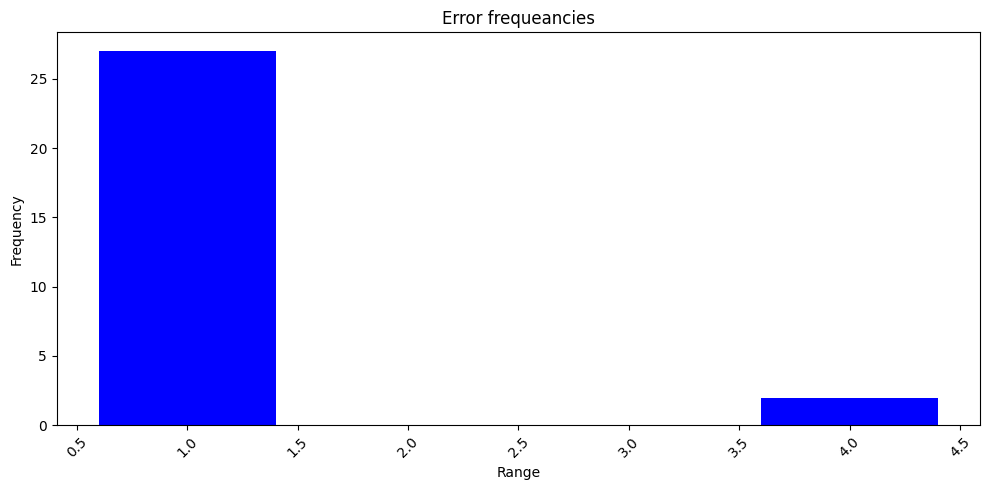

{np.int64(1): np.int64(27), np.int64(4): np.int64(2)}
Error mean: 1.206896551724138
Error rate: 11.24031007751938 %
Overall mean: 0.13565891472868216
Accuracy: 0.8875968992248062 
 Precision: 0.892980418735664 
 Recall: 0.8875968992248062 
 F1 Score: 0.8885300939011497
Confusion Matrix:
 [[ 34  11   0   0   0]
 [  4  83   4   0   0]
 [  0   4 108   3   0]
 [  0   0   1   3   1]
 [  0   0   0   1   1]]


In [21]:
classify(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=42), classifier_name="RandomForestClassifier")

### SVM
Much higher computational cost, more distributed error, but in overall worse result

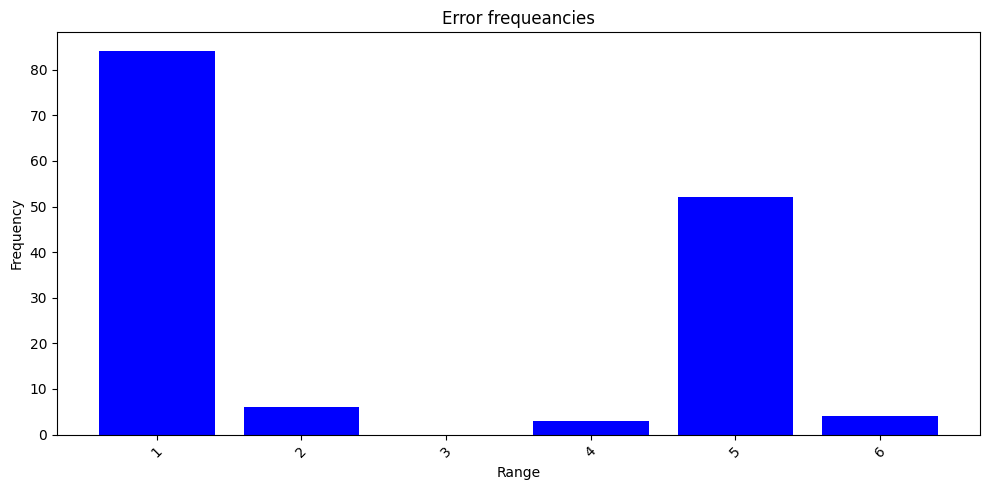

{np.int64(1): np.int64(84), np.int64(2): np.int64(6), np.int64(4): np.int64(3), np.int64(5): np.int64(52), np.int64(6): np.int64(4)}
Error mean: 2.6308724832214767
Error rate: 57.751937984496124 %
Overall mean: 1.5193798449612403
Accuracy: 0.42248062015503873 
 Precision: 0.5908550078294538 
 Recall: 0.42248062015503873 
 F1 Score: 0.44597441275267913
Confusion Matrix:
 [[27 17  1  0  0]
 [26 52  9  0  4]
 [ 3 32 28  0 52]
 [ 0  2  0  0  3]
 [ 0  0  0  0  2]]


C:\Users\Giovanni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
classify(X_train_resampled, X_test, y_train_resampled, y_test, SVC(random_state=42), classifier_name="SVC")

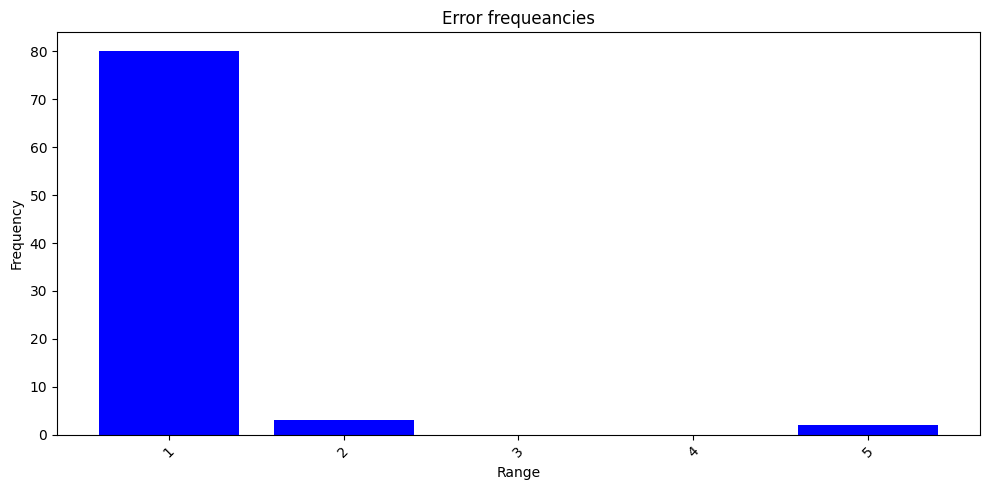

{np.int64(1): np.int64(80), np.int64(2): np.int64(3), np.int64(5): np.int64(2)}
Error mean: 1.1294117647058823
Error rate: 32.945736434108525 %
Overall mean: 0.37209302325581395
Accuracy: 0.6705426356589147 
 Precision: 0.6870694366541542 
 Recall: 0.6705426356589147 
 F1 Score: 0.662936896601902
Confusion Matrix:
 [[21 23  1  0  0]
 [ 7 72 12  0  0]
 [ 0 35 80  0  0]
 [ 0  2  3  0  0]
 [ 0  0  2  0  0]]


C:\Users\Giovanni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
classify(X_train, X_test, y_train, y_test, SVC(random_state=42), classifier_name="SVC")

### Naive bayes

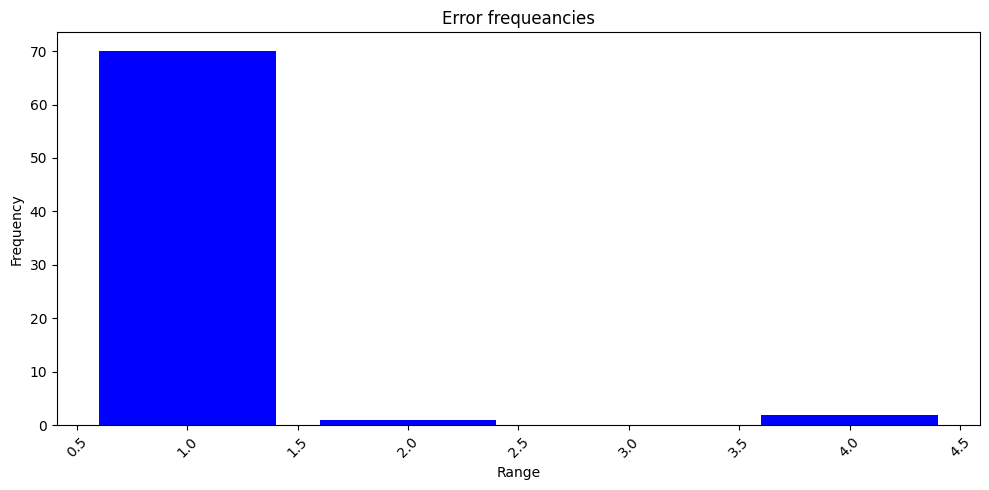

{np.int64(1): np.int64(70), np.int64(2): np.int64(1), np.int64(4): np.int64(2)}
Error mean: 1.095890410958904
Error rate: 28.294573643410853 %
Overall mean: 0.31007751937984496
Accuracy: 0.7170542635658915 
 Precision: 0.7546521382069782 
 Recall: 0.7170542635658915 
 F1 Score: 0.7269944537048775
Confusion Matrix:
 [[38  7  0  0  0]
 [21 59 10  1  0]
 [ 0 22 83 10  0]
 [ 0  0  0  3  2]
 [ 0  0  0  0  2]]


In [24]:
classify(X_train, X_test, y_train, y_test, GaussianNB(), classifier_name="Naive bayes")

### ANN

In [25]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(data[['price_categ']])

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    gas_cars_encoded, y_encoded, test_size=0.3, random_state=42
)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Define the ANN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Softmax for multi-class classification

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

Epoch 1/100


C:\Users\Giovanni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4750 - loss: 1.3501 - val_accuracy: 0.7519 - val_loss: 0.7926
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8219 - loss: 0.6483 - val_accuracy: 0.7959 - val_loss: 0.6152
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8530 - loss: 0.4658 - val_accuracy: 0.8010 - val_loss: 0.5506
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8853 - loss: 0.3465 - val_accuracy: 0.8114 - val_loss: 0.5283
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8929 - loss: 0.2853 - val_accuracy: 0.8088 - val_loss: 0.5184
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9002 - loss: 0.2687 - val_accuracy: 0.8243 - val_loss: 0.5245
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9319 - loss: 0.2209 - val_accuracy: 0.8088 - val_loss: 0.5383
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9199 - loss: 0.2179 - val_accuracy: 0.8036 - val_loss: 0.5423
Epoc

In [26]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [27]:
Evaluator.eval_classification(y_pred=y_pred_classes, y_true=y_test_classes, binary_classification=False, classifier_name="ANN")

Accuracy: 0.8914728682170543 
 Precision: 0.8981227970025875 
 Recall: 0.8914728682170543 
 F1 Score: 0.8916188613863032
Confusion Matrix:
 [[ 67   6   0   0   0]
 [  8 124   5   1   0]
 [  0  12 144   5   0]
 [  0   0   1   7   0]
 [  0   0   4   0   3]]


## Regression

In [28]:
X_train, X_test, y_train, y_test = train_test_split(gas_cars_encoded, precios_gas, test_size=0.3, random_state=42)

In [29]:
def regression(X_train, X_test, y_train, y_test , regressor, regressor_name = None) -> None:
    regressor = regressor
    regressor.fit(X_train, y_train)
    # Predicting the test set results
    y_pred = regressor.predict(X_test)

    if regressor_name != None:
        Evaluator.eval_regression(y_pred = y_pred, bins=5, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name=regressor_name)
    Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False)

### Cart

In [30]:
regression(X_train, X_test, y_train, y_test , DecisionTreeRegressor(random_state=42), regressor_name="CART")

MAE: 778.6821705426356 
 MSE: 1756751.4832041343 
 RMSE: 1325.4250198348204 
 R2: 0.9392498322248869 
 MAPE: 5.435493931683752
Mean: 778.6821705426356
Variance: 1150405.5604831441
Standard Deviation: 1072.569606358088
r2_adjusted: 1.0027535890983084
MAE: 778.6821705426356 
 MSE: 1756751.4832041343 
 RMSE: 1325.4250198348204 
 R2: 0.9392498322248869 
 MAPE: 5.435493931683752
Mean: 778.6821705426356
Variance: 1150405.5604831441
Standard Deviation: 1072.569606358088


### Cart Optimized Hyperparameters with Optuna

### Random Forest

In [31]:
regression(X_train, X_test, y_train, y_test , RandomForestRegressor(random_state=42), regressor_name="RandomForest")

MAE: 698.2293453919034 
 MSE: 1191656.5749760407 
 RMSE: 1091.6302372946807 
 R2: 0.9587913614690262 
 MAPE: 4.729197986887422
Mean: 698.2293453919034
Variance: 704132.3562096347
Standard Deviation: 839.1259477632871
r2_adjusted: 1.001867841060704
MAE: 698.2293453919034 
 MSE: 1191656.5749760407 
 RMSE: 1091.6302372946807 
 R2: 0.9587913614690262 
 MAPE: 4.729197986887422
Mean: 698.2293453919034
Variance: 704132.3562096347
Standard Deviation: 839.1259477632871


### SVM Regression

In [32]:
regression(X_train, X_test, y_train, y_test , SVR(kernel='rbf'), regressor_name="SVR")

MAE: 4216.647411894322 
 MSE: 29859873.379807062 
 RMSE: 5464.4188510588265 
 R2: -0.032583341986641035 
 MAPE: 29.52476290334598
Mean: 4216.647411894322
Variance: 12079757.983571967
Standard Deviation: 3475.594623020925
r2_adjusted: 1.0468033313770366
MAE: 4216.647411894322 
 MSE: 29859873.379807062 
 RMSE: 5464.4188510588265 
 R2: -0.032583341986641035 
 MAPE: 29.52476290334598
Mean: 4216.647411894322
Variance: 12079757.983571967
Standard Deviation: 3475.594623020925


### Multivariable regression

In [33]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = linear_regressor.predict(X_test)

# Optionally, display the coefficients of the model
print("Coefficients:", linear_regressor.coef_)
print("Intercept:", linear_regressor.intercept_)

Coefficients: [-9.72049139e+02  9.40775998e+02 -9.98952329e+13 ...  0.00000000e+00
  0.00000000e+00  1.02592943e+13]
Intercept: -83941447848023.97


In [34]:
result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
result["diff"] = result["Real"].to_numpy() - result["Prediction"].to_numpy()

In [35]:
result

,Real,Prediction,diff
idx,,,
162056,17500,-3.847466e+11,3.847466e+11
39072,14800,1.483125e+04,-3.125000e+01
116181,14990,3.805338e+04,-2.306338e+04
45240,8590,8.043094e+03,5.469062e+02
156962,16900,-1.552437e+13,1.552437e+13
...,...,...,...
63532,11500,1.120791e+04,2.920938e+02
79243,11487,1.189759e+04,-4.105938e+02
37736,33900,1.063472e+12,-1.063472e+12


 ### ANN

In [36]:
# Define the model
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
model.add(Dense(1))


C:\Users\Giovanni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [38]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 242922512.0000 - mae: 14693.0078 - val_loss: 258333984.0000 - val_mae: 15146.5400
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 245371344.0000 - mae: 14741.6094 - val_loss: 258201632.0000 - val_mae: 15142.3291
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 241199072.0000 - mae: 14624.8965 - val_loss: 257850336.0000 - val_mae: 15131.1553
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 240653808.0000 - mae: 14618.2383 - val_loss: 257004736.0000 - val_mae: 15104.2949
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 244128432.0000 - mae: 14731.7490 - val_loss: 255133808.0000 - val_mae: 15044.8486
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 240620768.0000 - mae: 14648.2852 - val_loss: 251272816.0000 - val_mae: 14921.3311
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 240193952.0000 - mae: 14553.7422 - val_loss: 243841376.0000 - val_mae: 14681.5928
Epoch 8/100
8/8 ━━━━

In [39]:
loss, mae = model.evaluate(X_test, y_test, verbose=2)
print(f"Mean Absolute Error on test set: {mae:.2f}")

13/13 - 0s - 3ms/step - loss: 1544890.0000 - mae: 900.6795
Mean Absolute Error on test set: 900.68


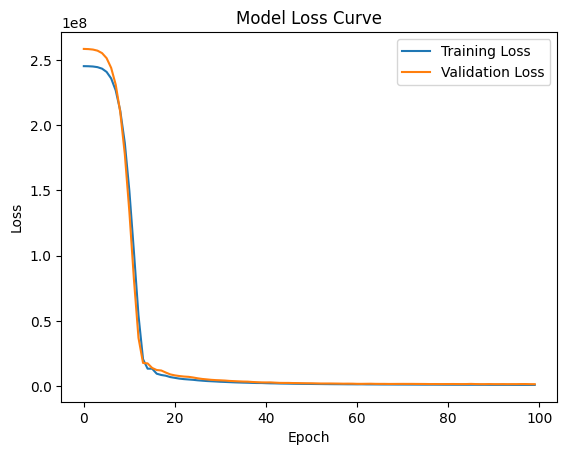

In [40]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Curve')
plt.show()

In [41]:
y_pred = model.predict(X_test).flatten()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [42]:
Evaluator.eval_regression(y_pred=y_pred, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name="ANN")

MAE: 900.6794667009851 
 MSE: 1544890.0714234954 
 RMSE: 1242.9360689204798 
 R2: 0.9465761780738831 
 MAPE: 6.288099811699722
Mean: 900.6794667009851
Variance: 733666.5696867246
Standard Deviation: 856.5433845910694
r2_adjusted: 1.0024215118909676


,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(11180.0, 5590.0]",775.893292,496562.833154,704.672146,3456.324219,11.699707,106
1,"(16770.0, 11180.0]",865.477236,590084.573897,768.169626,3425.470703,3.806641,142
2,"(22360.0, 16770.0]",784.827064,625811.032932,791.082191,3661.685547,4.605469,104


In [43]:
Evaluator.save("gas")

Regression results saved to: evaluation/gas_regression.tex
Classification results saved to: evaluation/gas_classification.tex


# Hyperparameter Tunning

In [44]:
gas_cars_encoded["price_categ"]

idx
143      -0.320203
576      -1.294439
644       0.654032
769       1.628268
787      -0.320203
            ...   
164584   -0.320203
164594   -0.320203
164639   -0.320203
164670   -1.294439
164681   -0.320203
Name: price_categ, Length: 1287, dtype: float64

In [45]:
master = MasterGenerator(X=gas_cars_encoded.drop(columns=["price_categ"]), y_categ=target["price_categ"], y_numeric=precios_gas, n_tries=128, CUML=True, name="HP_gas")

In [46]:
master.generate()

[I 2024-12-22 01:11:05,442] A new study created in memory with name: no-name-9e9da73e-1ec4-4e83-98e3-ae2093f7e62a


Optimizing algorithm: cart


[I 2024-12-22 01:11:06,092] Trial 0 finished with value: 30.91531687879485 and parameters: {'max_depth': 29, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 'log2', 'criterion': 'poisson'}. Best is trial 0 with value: 30.91531687879485.
[I 2024-12-22 01:11:06,962] Trial 1 finished with value: 30.46060393401579 and parameters: {'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'criterion': 'poisson'}. Best is trial 1 with value: 30.46060393401579.
[I 2024-12-22 01:11:07,590] Trial 2 finished with value: 29.658283957077657 and parameters: {'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'log2', 'criterion': 'absolute_error'}. Best is trial 2 with value: 29.658283957077657.
[I 2024-12-22 01:11:08,445] Trial 3 finished with value: 30.91531687879485 and parameters: {'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'criterion': 'friedman_mse'}. Best is trial 2 with va

MAE: 1082.4941860465117 
 MSE: 2647066.423449612 
 RMSE: 1626.9807692316501 
 R2: 0.9015180237732905 
 MAPE: 7.68194408747884
Mean: 1082.4941860465117
Variance: 1475272.7606251126
Standard Deviation: 1214.6080687304495
r2_adjusted: 1.0029280272894798
Optimizing algorithm: random_forest


[I 2024-12-22 01:13:13,417] Trial 0 finished with value: 30.019472164238696 and parameters: {'n_estimators': 100, 'max_depth': 438, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 30.019472164238696.
[I 2024-12-22 01:13:15,848] Trial 1 finished with value: 14.231846642064003 and parameters: {'n_estimators': 200, 'max_depth': 409, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 14.231846642064003.
[I 2024-12-22 01:13:25,516] Trial 2 finished with value: 8.680168989175506 and parameters: {'n_estimators': 200, 'max_depth': 297, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': False}. Best is trial 2 with value: 8.680168989175506.
[I 2024-12-22 01:13:39,810] Trial 3 finished with value: 8.557492800134971 and parameters: {'n_estimators': 450, 'max_depth': 370, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_featu

MAE: 830.2297138396704 
 MSE: 1691093.1399558056 
 RMSE: 1300.420370478641 
 R2: 0.9370842405272006 
 MAPE: 6.063052776066848
Mean: 830.2297138396704
Variance: 1001811.7622135049
Standard Deviation: 1000.9054711677346
r2_adjusted: 1.0018705865553574
Optimizing algorithm: svr


[I 2024-12-22 01:27:26,862] Trial 0 finished with value: 29.65822894908154 and parameters: {'kernel': 'poly', 'C': 0.0437992979609361, 'epsilon': 0.0028442408332978483, 'degree': 2, 'coef0': 0.29575951655429367, 'gamma': 'auto', 'max_iter': 4000}. Best is trial 0 with value: 29.65822894908154.
[I 2024-12-22 01:27:33,311] Trial 1 finished with value: 29.631154596677302 and parameters: {'kernel': 'rbf', 'C': 0.09669656453470978, 'epsilon': 0.041561664380476405, 'gamma': 'scale', 'max_iter': 6000}. Best is trial 1 with value: 29.631154596677302.
[I 2024-12-22 01:27:39,351] Trial 2 finished with value: 29.65170743210966 and parameters: {'kernel': 'sigmoid', 'C': 0.022745996993269083, 'epsilon': 0.30728553383272406, 'coef0': 0.2479157288844166, 'gamma': 'scale', 'max_iter': 3000}. Best is trial 1 with value: 29.631154596677302.
[I 2024-12-22 01:27:45,060] Trial 3 finished with value: 29.65054974438482 and parameters: {'kernel': 'sigmoid', 'C': 3.9545116449833024, 'epsilon': 0.69082959019965

MAE: 936.2511177353275 
 MSE: 1865261.6907632882 
 RMSE: 1365.7458368097953 
 R2: 0.9306044397454317 
 MAPE: 6.634142014279684
Mean: 936.2511177353275
Variance: 988695.5353026383
Standard Deviation: 994.3317028550575
r2_adjusted: 1.0020632414374624
Optimizing algorithm: linear_regression


[I 2024-12-22 01:36:45,206] Trial 0 finished with value: 99.23317578461844 and parameters: {}. Best is trial 0 with value: 99.23317578461844.
[I 2024-12-22 01:36:46,920] Trial 1 finished with value: 99.23317578461844 and parameters: {}. Best is trial 0 with value: 99.23317578461844.
[I 2024-12-22 01:36:48,453] Trial 2 finished with value: 99.23317578461844 and parameters: {}. Best is trial 0 with value: 99.23317578461844.
[I 2024-12-22 01:36:50,280] Trial 3 finished with value: 99.23317578461844 and parameters: {}. Best is trial 0 with value: 99.23317578461844.
[I 2024-12-22 01:36:51,805] Trial 4 finished with value: 99.23317578461844 and parameters: {}. Best is trial 0 with value: 99.23317578461844.
[I 2024-12-22 01:36:53,652] Trial 5 finished with value: 99.23317578461844 and parameters: {}. Best is trial 0 with value: 99.23317578461844.
[I 2024-12-22 01:36:55,172] Trial 6 finished with value: 99.23317578461844 and parameters: {}. Best is trial 0 with value: 99.23317578461844.
[I 202

MAE: 12176.079760174418 
 MSE: 2016507282.7561612 
 RMSE: 44905.537328442704 
 R2: -74.02252960205078 
 MAPE: 99.23317578461844
Mean: 12176.079760174418
Variance: 1868250364.4300323
Standard Deviation: 43223.261843942695
r2_adjusted: 3.2305402716019262
Regression results saved to: evaluation/HP_gas_regression.tex
Classification results saved to: evaluation/HP_gas_classification.tex
Optimizing method: decision_tree


[I 2024-12-22 01:40:17,309] Trial 0 finished with value: 0.8178294573643411 and parameters: {'max_depth': 21, 'min_samples_split': 15, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8178294573643411.
[I 2024-12-22 01:40:17,419] Trial 1 finished with value: 0.7441860465116279 and parameters: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8178294573643411.
[I 2024-12-22 01:40:17,537] Trial 2 finished with value: 0.8178294573643411 and parameters: {'max_depth': 23, 'min_samples_split': 19, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8178294573643411.
[I 2024-12-22 01:40:17,669] Trial 3 finished with value: 0.8255813953488372 and parameters: {'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8255813953488372.
[I 2024-12-22 01:40:17,788] Trial 4 finished with value: 0.8255813953488372 and parameters: {'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 9}. Best is trial 3 

Optimizing method: random_forest


[I 2024-12-22 01:40:34,358] Trial 0 finished with value: 0.6821705426356589 and parameters: {'n_estimators': 50, 'max_depth': 265, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.6821705426356589.
[I 2024-12-22 01:40:34,807] Trial 1 finished with value: 0.748062015503876 and parameters: {'n_estimators': 150, 'max_depth': 239, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.748062015503876.
[I 2024-12-22 01:40:35,347] Trial 2 finished with value: 0.6976744186046512 and parameters: {'n_estimators': 250, 'max_depth': 283, 'min_samples_split': 20, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.748062015503876.
[I 2024-12-22 01:40:39,451] Trial 3 finished with value: 0.8410852713178295 and parameters: {'n_estimators': 150, 'max_depth': 349, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.8410852713178295.
[I 2024-12-22 01:40:39,929] Trial 4 finished with value: 0.6976744186046512 and paramete

Optimizing method: svc


[I 2024-12-22 01:45:41,233] Trial 0 finished with value: 0.8217054263565892 and parameters: {'C': 0.69475643705148, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 0 with value: 0.8217054263565892.
[I 2024-12-22 01:45:44,545] Trial 1 finished with value: 0.7558139534883721 and parameters: {'C': 0.530996640277961, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 0 with value: 0.8217054263565892.
[I 2024-12-22 01:45:49,966] Trial 2 finished with value: 0.44573643410852715 and parameters: {'C': 0.10038630820285295, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.8217054263565892.
[I 2024-12-22 01:45:55,427] Trial 3 finished with value: 0.44573643410852715 and parameters: {'C': 0.21080873035327424, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.8217054263565892.
[I 2024-12-22 01:45:57,521] Trial 4 finished with value: 0.686046511627907 and parameters: {'C': 35.7532803939338, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 0 with valu

Optimizing method: kmeans


[I 2024-12-22 01:52:05,668] Trial 0 finished with value: 0.237452065942712 and parameters: {'n_clusters': 14, 'init': 'random', 'n_init': 39, 'max_iter': 461}. Best is trial 0 with value: 0.237452065942712.
[I 2024-12-22 01:52:11,917] Trial 1 finished with value: 0.21953299129580392 and parameters: {'n_clusters': 12, 'init': 'random', 'n_init': 49, 'max_iter': 190}. Best is trial 0 with value: 0.237452065942712.
[I 2024-12-22 01:52:14,620] Trial 2 finished with value: 0.20476408964718415 and parameters: {'n_clusters': 7, 'init': 'k-means++', 'n_init': 16, 'max_iter': 313}. Best is trial 0 with value: 0.237452065942712.
[I 2024-12-22 01:52:16,315] Trial 3 finished with value: 0.20703471963033648 and parameters: {'n_clusters': 6, 'init': 'random', 'n_init': 11, 'max_iter': 371}. Best is trial 0 with value: 0.237452065942712.
[I 2024-12-22 01:52:22,732] Trial 4 finished with value: 0.23518904783437453 and parameters: {'n_clusters': 14, 'init': 'random', 'n_init': 43, 'max_iter': 126}. Bes

Optimizing method: agglomerative


[I 2024-12-22 02:00:51,276] Trial 0 finished with value: 0.22645568909658984 and parameters: {'n_clusters': 12, 'linkage': 'ward'}. Best is trial 0 with value: 0.22645568909658984.
[I 2024-12-22 02:00:54,209] Trial 1 finished with value: 0.22093751449525273 and parameters: {'n_clusters': 11, 'linkage': 'ward'}. Best is trial 0 with value: 0.22645568909658984.
[I 2024-12-22 02:01:00,767] Trial 2 finished with value: 0.1718853856453811 and parameters: {'n_clusters': 7, 'linkage': 'single'}. Best is trial 0 with value: 0.22645568909658984.
[I 2024-12-22 02:01:03,671] Trial 3 finished with value: 0.2068637091675589 and parameters: {'n_clusters': 8, 'linkage': 'ward'}. Best is trial 0 with value: 0.22645568909658984.
[I 2024-12-22 02:01:06,589] Trial 4 finished with value: 0.38330422472419223 and parameters: {'n_clusters': 3, 'linkage': 'average'}. Best is trial 4 with value: 0.38330422472419223.
[I 2024-12-22 02:01:09,498] Trial 5 finished with value: 0.24101173181402918 and parameters: {'

Optimizing method: dbscan


[I 2024-12-22 02:11:57,803] Trial 0 finished with value: -0.13328248602113116 and parameters: {'eps': 1.4837388617463871, 'min_samples': 18, 'algorithm': 'ball_tree'}. Best is trial 0 with value: -0.13328248602113116.
[I 2024-12-22 02:11:58,792] Trial 1 finished with value: -0.13058686073754658 and parameters: {'eps': 1.4887262150523635, 'min_samples': 12, 'algorithm': 'brute'}. Best is trial 1 with value: -0.13058686073754658.
[I 2024-12-22 02:11:59,795] Trial 2 finished with value: -0.10299994489240397 and parameters: {'eps': 1.9206371179475477, 'min_samples': 15, 'algorithm': 'brute'}. Best is trial 2 with value: -0.10299994489240397.
[I 2024-12-22 02:12:00,913] Trial 3 finished with value: 0.11459224418690896 and parameters: {'eps': 3.7540331084651943, 'min_samples': 17, 'algorithm': 'auto'}. Best is trial 3 with value: 0.11459224418690896.
[I 2024-12-22 02:12:02,014] Trial 4 finished with value: -0.0005673925491648101 and parameters: {'eps': 2.1276067584977847, 'min_samples': 9, '

Optimizing method: birch


[I 2024-12-22 02:18:09,624] Trial 0 finished with value: 0.2580358672668123 and parameters: {'threshold': 0.8809587303570645, 'n_clusters': 15, 'branching_factor': 89}. Best is trial 0 with value: 0.2580358672668123.
[I 2024-12-22 02:18:12,035] Trial 1 finished with value: 0.25715454292006745 and parameters: {'threshold': 0.8677197322220733, 'n_clusters': 7, 'branching_factor': 14}. Best is trial 0 with value: 0.2580358672668123.
[I 2024-12-22 02:18:15,458] Trial 2 finished with value: 0.2135374476370951 and parameters: {'threshold': 0.5640575410160485, 'n_clusters': 9, 'branching_factor': 12}. Best is trial 0 with value: 0.2580358672668123.
[I 2024-12-22 02:18:17,718] Trial 3 finished with value: 0.22696733854709195 and parameters: {'threshold': 0.8844887519678682, 'n_clusters': 4, 'branching_factor': 35}. Best is trial 0 with value: 0.2580358672668123.
[I 2024-12-22 02:18:20,213] Trial 4 finished with value: 0.2168542525348929 and parameters: {'threshold': 0.8399868562630157, 'n_clus

Optimizing method: optics


[I 2024-12-22 02:27:57,787] Trial 0 finished with value: 0.09030540749548922 and parameters: {'min_samples': 11, 'max_eps': 0.6284849521102379, 'metric': 'cosine', 'cluster_method': 'xi'}. Best is trial 0 with value: 0.09030540749548922.
[I 2024-12-22 02:28:05,283] Trial 1 finished with value: -0.19181463968726725 and parameters: {'min_samples': 5, 'max_eps': 3.3456959162563233, 'metric': 'manhattan', 'cluster_method': 'xi'}. Best is trial 0 with value: 0.09030540749548922.
[I 2024-12-22 02:28:06,419] Trial 2 finished with value: 0.03335878307037868 and parameters: {'min_samples': 9, 'max_eps': 0.2545658707776433, 'metric': 'euclidean', 'cluster_method': 'xi'}. Best is trial 0 with value: 0.09030540749548922.
[I 2024-12-22 02:28:09,427] Trial 3 finished with value: -0.2636859303424341 and parameters: {'min_samples': 4, 'max_eps': 1.0200947528228876, 'metric': 'euclidean', 'cluster_method': 'dbscan'}. Best is trial 0 with value: 0.09030540749548922.
[I 2024-12-22 02:31:11,180] Trial 4 f

Optimizing method: gmm


[W 2024-12-22 07:51:29,657] Trial 0 failed with parameters: {'n_components': 11, 'covariance_type': 'full', 'tol': 0.00805143350738027, 'reg_covar': 0.005899616893920807, 'max_iter': 194} because of the following error: MemoryError((11, 8901, 8901), dtype('float64')).
Traceback (most recent call last):
  File "C:\Users\Giovanni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "d:\Duesto Uni\3 anio\Machine Learning\Proyecto\Cars_Price_Prediction\Trees\..\utils\cluster_generator.py", line 100, in <lambda>
    study.optimize(lambda trial: self._objective(trial, method), n_trials=n_trials)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Duesto Uni\3 anio\Machine Learning\Proyecto\Cars_Price_Prediction\Trees\..\utils\cluster_generator.py", line 81, in _objective
   

Error with method gmm: Unable to allocate 6.49 GiB for an array with shape (11, 8901, 8901) and data type float64
